<h1 align="center">Variational Autoencoder</h1> 

In [1]:
import lovely_tensors as lt
from omegaconf import OmegaConf
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from ldm.models.autoencoder import AutoencoderKL

from helper import ForwardDiffusionProcessor, download_images, X2imgs, imgs2X

lt.monkey_patch()

/home/chris/miniconda3/envs/stable-diffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module 'xformers'. Proceeding without it.


In [2]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# laod the weights
ckpt = "v2-1_512-ema-pruned.ckpt"
state_dict = torch.load(ckpt, map_location="cpu")["state_dict"]

state_dict_vae = {}
for k, v in state_dict.items():
    if k.startswith("first_stage_model."):
        state_dict_vae[k.replace("first_stage_model.", "")] = v

# load the parameters
config_path = "../stablediffusion-repo/configs/stable-diffusion/v2-inference.yaml"
cfg = OmegaConf.load(config_path)

# load the variational autoencoder
vae = AutoencoderKL(**cfg.model.params.first_stage_config.params)
vae.load_state_dict(state_dict_vae, strict=True)
vae.to(device)
vae.eval()

pass

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


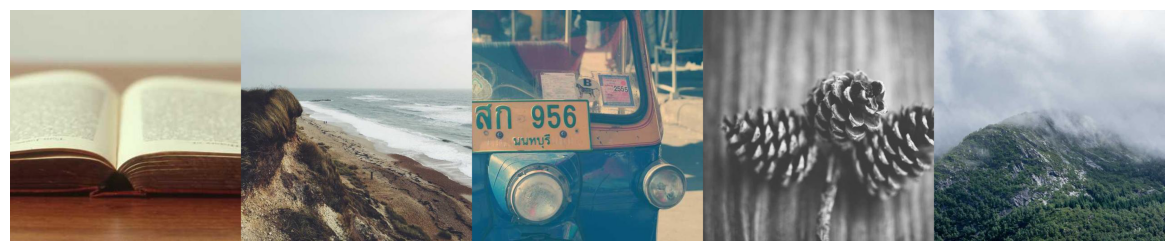

In [3]:
# Download some random images
imgs = download_images(n=5, res=512)
plt.figure(figsize=(20, 3))
plt.imshow(np.hstack(imgs))
plt.axis("off")
plt.show()

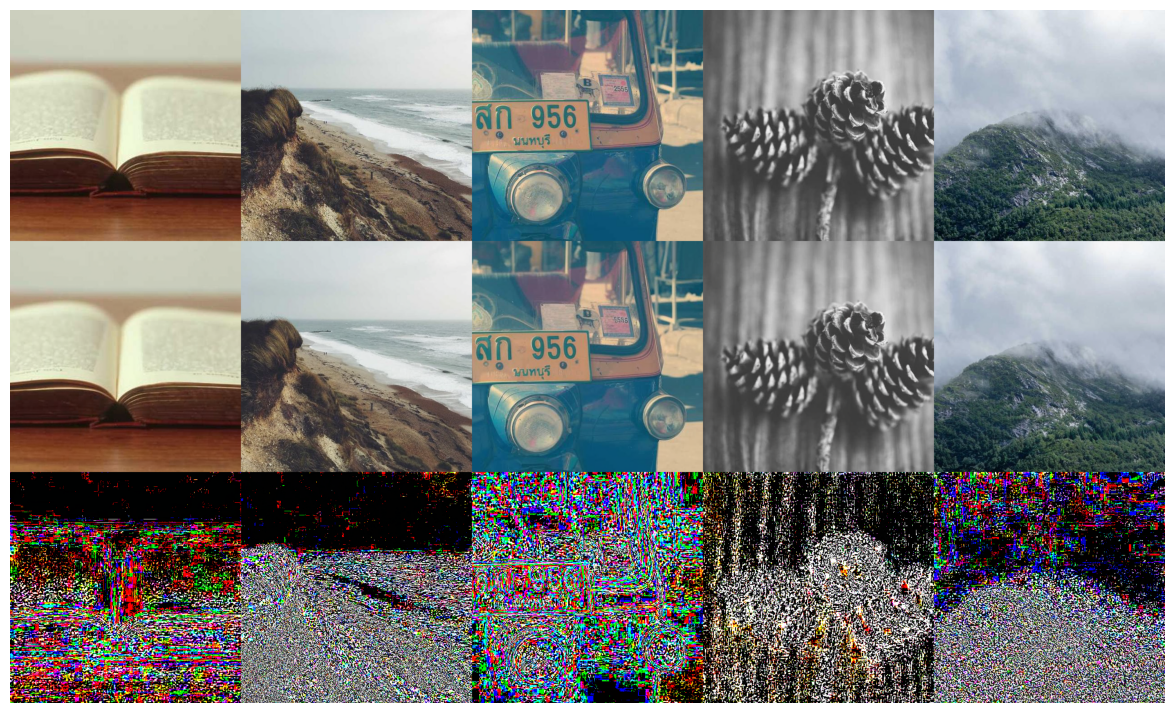

In [4]:
# Autoencoding all images
X = imgs2X(imgs, device)
with torch.no_grad(), torch.cuda.amp.autocast():
    posterior = vae.encode(X)
    Z = posterior.sample()
    X_tilde = vae.decode(Z)
imgs_reconstructed = X2imgs(X_tilde)

# Plot the result
diff = np.abs(imgs - imgs_reconstructed)
viz = np.vstack([
        np.hstack(imgs),
        np.hstack(imgs_reconstructed),
        np.hstack(diff)
])

plt.figure(figsize=(20, 9))
plt.imshow(viz)
plt.axis("off")
plt.show()

### Value ranges of the latent space

In [5]:
def autoencode_random_image():

    imgs = download_images(n=1, res=512)
    
    X = imgs2X(imgs, device)
    with torch.no_grad(), torch.cuda.amp.autocast():
        posterior = vae.encode(X)
        Z = posterior.sample()
        X_tilde = vae.decode(Z)
    imgs_reconstructed = X2imgs(X_tilde)

    latent = Z.cpu().numpy()
    img = imgs[0]
    img_reconstructed = imgs_reconstructed[0]

    return img, img_reconstructed, latent

n = 100
latents = []
for _ in tqdm(range(n)):
    _, _, latent = autoencode_random_image()
    latents.append(latent)
latents = np.vstack(latents)

print("Mean value of the latent space: ", np.mean(latents))
print("Std value of the latent space:  ", np.std(latents))
print("1/cfg.model.params.scale_factor:", 1/cfg.model.params.scale_factor)

100%|██████████| 100/100 [00:24<00:00,  4.16it/s]

Mean value of the latent space:  0.49753147
Std value of the latent space:   5.2379513
1/cfg.model.params.scale_factor: 5.489980785067252


### Little Appendix on how bad the L1 norm is for image reconstruction

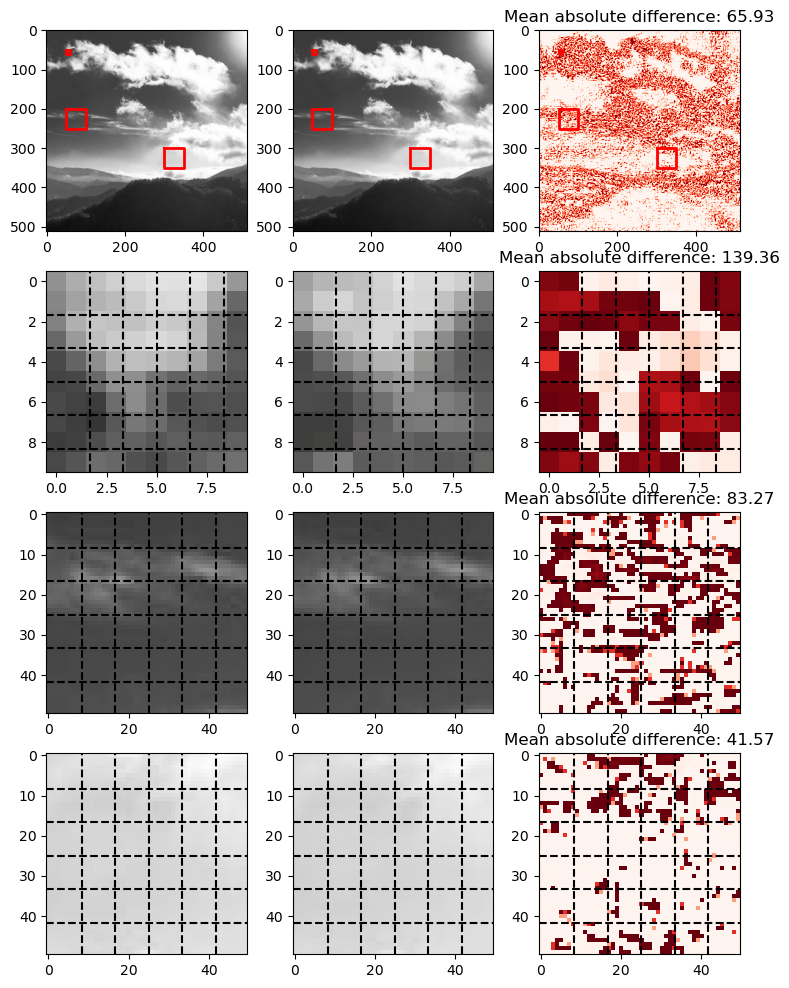

In [6]:
img, img_reconstructed, latent = autoencode_random_image()

bboxs = [
    (50, 60, 50, 60),
    (200, 250, 50, 100),
    (300, 350, 300, 350),
]
diff = np.abs(img - img_reconstructed).mean(axis=-1)

fig, axs = plt.subplots(len(bboxs) + 1, 3, figsize=(9, 12))

axs[0,0].imshow(img)
axs[0,1].imshow(img_reconstructed)
axs[0,2].imshow(diff, cmap="Reds", vmin=0, vmax=255)
axs[0,2].set_title(f"Mean absolute difference: {diff.mean():.2f}")

for i, bbox in enumerate(bboxs):
    i1, i2, j1, j2 = bbox
    img_ = img[i1:i2, j1:j2]
    img_reconstructed_ = img_reconstructed[i1:i2, j1:j2]
    diff_ = diff[i1:i2, j1:j2]

    axs[i+1,0].imshow(img_)
    axs[i+1,1].imshow(img_reconstructed_)
    axs[i+1,2].imshow(diff_, cmap="Reds", vmin=0, vmax=255)
    axs[i+1,2].set_title(f"Mean absolute difference: {diff_.mean():.2f}")

    for j in range(3):
        # add bounding box in original image
        axs[0,j].plot([j1,j1,j2,j2,j1], [i1,i2,i2,i1,i1], color="red", linewidth=2)

        # add a grind
        [axs[i+1,j].axhline(_i, color="black", linestyle="--") for _i in np.linspace(i1, i2, 7)[1:-1] - i1]
        [axs[i+1,j].axvline(_j, color="black", linestyle="--") for _j in np.linspace(j1, j2, 7)[1:-1] - j1]
    